# <a id='toc1_'></a>[Telecom ¿El usuario planea irse?](#toc0_)

**Tabla de Contenido**<a id='toc0_'></a>    
- [Telecom ¿El usuario planea irse?](#toc1_)    
  - [Descripción](#toc1_1_)    
    - [Servicios de Interconnect](#toc1_1_1_)    
  - [Descripción de los datos](#toc1_2_)    
  - [Carga de librerías](#toc1_3_)    
  - [Funciones](#toc1_4_)    
  - [EDA](#toc1_5_)    
    - [Contract](#toc1_5_1_)     
    - [Personal](#toc1_5_4_)    
    - [Internet](#toc1_5_5_)    
    - [Phone](#toc1_5_6_)    
  - [Preparación de los datos](#toc1_6_)    
    - [Balanceo por sobremuestreo](#toc1_6_1_)    
    - [División en conjunto prueba y entrenamiento](#toc1_6_2_)    
    - [One Hot-Encoding](#toc1_6_3_)    
    - [Label Encoder](#toc1_6_4_)    
    - [Escalado de datos (MixMaxScaler)](#toc1_6_5_)    
  - [Feature engineering](#toc1_7_)    
    - [Correlación de características númericas](#toc1_7_1_)    
    - [Boruta](#toc1_7_2_)    
    - [SHAP](#toc1_7_3_)    
    - [Regularización del Lasso](#toc1_7_4_)    
    - [Selección de características](#toc1_7_5_)    
  - [Modelado](#toc1_8_)    
    - [Dummy model](#toc1_8_1_)    
    - [Logistic Regression model](#toc1_8_2_)    
    - [Catboost model](#toc1_8_3_)    
    - [LightGBM model](#toc1_8_4_)    
    - [XGBoost model](#toc1_8_5_)    
  - [Conclusiones y recomendaciones](#toc1_9_)    
  - [Informe](#toc1_10_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Descripción](#toc0_)
Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

### <a id='toc1_1_1_'></a>[Servicios de Interconnect](#toc0_)

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

## <a id='toc1_2_'></a>[Descripción de los datos](#toc0_)

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

## <a id='toc1_3_'></a>[Carga de librerías](#toc0_)

In [1]:
import re
from boruta import BorutaPy
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import auc, accuracy_score, average_precision_score, f1_score, mean_squared_error, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import scipy.stats as st
import shap
import xgboost as xgb

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## <a id='toc1_4_'></a>[Funciones](#toc0_)

In [96]:
def camelcase_to_snakecase(df):
    ''' Convierte las columnas de un dataframe de formato CamelCase
    a snake_case y minúsculas.
    in: dataframe con columnas CamelCase
    out: dataframe con columnas snake_case '''
    columns = df.columns
    new_col_names = []
    for col in columns:
        pattern = r'([a-z])([A-Z])' # Encuentra minúscula seguida de una mayúscula
        replace = r'\1_\2'          # Reemplaza por minúscula_mayúscula
        snke_case_name = re.sub(pattern=pattern, repl=replace, string=col)
        new_col_names.append(snke_case_name.lower())
    df.columns = new_col_names

def column_to_bool(df, columns):
    ''' Convierte el tipo de dato de las columnas con 2 categorias a bool. 
    columns: Columnas a las cuales se les aplicara la transformación. '''
    df = pd.get_dummies(df, columns=columns, drop_first=True)
    for col in df.columns:
        pattern = r'_([A-Z].*)'     # Encuentra el patron que agrega get_dummies
        replace = ''                # El reemplazo es una cadena vacia
        clean_name = re.sub(pattern=pattern, repl=replace, string=col)
        df = df.rename(columns={col:clean_name})
    return df 

def split_dates(df, date_column, prefix):
    ''' Separa la columna de fecha tipo datetime en 2 distinas columnas (mes/año).
    date_column: Columna con las fechas a dividir.
    prefix: nombre de la nueva columna. '''
    df[f'{prefix}_month'] = df[date_column].dt.month
    df[f'{prefix}_year'] = df[date_column].dt.year
    return df

def caculate_end_date_by_year(user_info, last_year=2020, last_month=2, add_n_years=None, add_n_months=None):
    ''' Calcula la fecha de terminacion de contrato de 1 o mas años.'''
    # Contrato por años
    # Para los que empezaron en el año actual
    if (user_info['begin_date'].year == last_year) & (add_n_years):
        return user_info['begin_date'] + pd.DateOffset(years=add_n_years) # Agrega años
    # Para los que empezaron el año anterior
    else:
        return pd.to_datetime(f'{last_year-1}-{user_info["begin_date"].month}-01') + pd.DateOffset(years=add_n_years)

def real_end_date(user_info):
    ''' Para las observaciones con valores NaT, se reemplazara la fecha de terminación
    por la fecha en la que acaba su contrato. 
    last_date: fecha actual'''
    last_date = '20-03-01'
    # Solo aplicar a los usuarios sin fecha de terminación
    if pd.isna(user_info['end_date']):
        type_contract = user_info['type'] # Extraer el tipo de contrato

        # Contrato mes a mes 
        # Para los que empezaron su contrato en febrero
        if (type_contract == 'Month-to-month') & (user_info['begin_date'].month == 2):
            return user_info['begin_date'] + pd.DateOffset(months=1) # Agregar un mes
        # Para los que empezaron su contrato en enero
        elif (type_contract == 'Month-to-month') & (user_info['begin_date'].month == 1):
            return pd.to_datetime('2020-02-01') # Vence en febrero
        
        # Dependiendo los años del contrato regresa una fecha
        elif type_contract == 'One year':
            return caculate_end_date_by_year(user_info, add_n_years=1)
        else:
            return caculate_end_date_by_year(user_info, add_n_years=2)
    else:
        return user_info['end_date']
    
def calculate_active_days(user_info):
    ''' Calcula los días en las que un usuario estuvo activo, limitado por el último dia registrado
    de cancelación/terminación de contrato. '''
    end_active_day = user_info['end_date_with_contract']
    # Limitar la fecha al último día registrado
    if end_active_day > pd.to_datetime('2020-01-01'):
        end_active_day = pd.to_datetime('2020-01-01')
    return (end_active_day - user_info['begin_date']).days

def is_active(user_info):
    ''' Verifica si la persona sigue activa.
    Si tiene NaT, significa que la persona esta activa y se pondra un True.
    En caso contrario se agrega un False.'''
    return pd.isna(user_info['end_date'])

def roc_auc_graph(model_predicts, title, target_test):
    ''' Calcula el area bajo la curva ROC-AUC. Guarda la imagen y la muestra.
    model_predicts_filepath: ubicación de las predicciones del modelo.
    image_name: Nombre de la imagen a crear (se guarda en png) en string, ejemplo: 'mi_imagen').
    title: Título mostrado en la imagen a crear.
    target_test_filepath: ubicación del objetivo de prueba.
    show_img: Si es true, mostrara la imagen en la pantalla.'''

    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(target_test, model_predicts)

    # Calcular el área bajo la curva ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Grafica la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def bargraph_users(df, columns, xlabel, title, legend_title, ylabel='Number of contracts', rotation=0):
    ''' Grafica el numero de contratos por año y tipo de contrato a partir de un dataset
    y el nombre de la columna.
    df: dataframe con los datos a graficar.
    columns: columnas a agrupar.
    xlabel: nombre del eje x.
    legend_title: titulo de la leyenda.
    ylabel: (numero de contratos por defaul), titulo del eje y.
    rotation: rotación de los nombres en el eje x.'''
    # Contar el número de contratos por año y tipo de contrato
    df_grouped = df.groupby(columns).size().unstack(fill_value=0)

    # Graficar
    ax = df_grouped.plot(kind='bar', figsize=(10, 6))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.xticks(rotation=rotation) 
    plt.legend(title=legend_title)
    plt.tight_layout()
    plt.show()

def evaluate_model(model, train_features, train_target, test_features, test_target, proba=True):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC-AUC
        fpr, tpr, roc_thresholds = roc_curve(target, pred_proba)
        roc_auc = roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = precision_recall_curve(target, pred_proba)
        aps = average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## <a id='toc1_5_'></a>[EDA](#toc0_)

In [3]:
# Carga de de dataframes
df_contract = pd.read_csv('../datasets/contract.csv', parse_dates=['BeginDate'])
df_internet = pd.read_csv('../datasets/internet.csv')
df_personal = pd.read_csv('../datasets/personal.csv')
df_phone    = pd.read_csv('../datasets/phone.csv')

### <a id='toc1_5_1_'></a>[Contract](#toc0_)

In [4]:
df_contract.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
25,6865-JZNKO,2017-08-01,No,Month-to-month,Yes,Bank transfer (automatic),55.30,1530.6
4404,1307-ATKGB,2018-02-01,No,Month-to-month,Yes,Electronic check,89.55,2187.15
825,2311-QYMUQ,2018-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Credit card (automatic),89.45,1430.25
241,6614-FHDBO,2014-02-01,No,Two year,No,Bank transfer (automatic),109.20,7878.3
1848,7190-XHTWJ,2016-12-01,No,One year,No,Mailed check,19.30,755.5
1908,8232-UTFOZ,2014-05-01,No,Two year,No,Credit card (automatic),19.95,1399.35
4587,5201-USSQZ,2017-12-01,No,Month-to-month,No,Credit card (automatic),85.90,2196.45
4920,0264-CNITK,2014-03-01,No,Two year,No,Bank transfer (automatic),20.10,1389.6
255,4111-BNXIF,2014-07-01,No,Two year,Yes,Electronic check,59.55,4103.9
1495,4472-VESGY,2015-10-01,No,Month-to-month,No,Bank transfer (automatic),98.15,4993.4


In [5]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


In [6]:
df_contract.describe()

,BeginDate,MonthlyCharges
count,7043,7043.000000
mean,2017-04-30 13:01:50.918642688,64.761692
min,2013-10-01 00:00:00,18.250000
25%,2015-06-01 00:00:00,35.500000
50%,2017-09-01 00:00:00,70.350000
75%,2019-04-01 00:00:00,89.850000
max,2020-02-01 00:00:00,118.750000
std,NaN,30.090047


TODO: 
- Cambiar el nombre de las columnas a minúscula y snake_case.
- Explorar total_charges.
- Cambiar el tipo de dato de endDate a datetime para extraer el mes y año. 
- Dividir endDate y BeginDate en columnas de mes y año respectivamente.
- Remplazar EndDate por una columna tipo bool. False para los clientes que no han cancelado y true para los que ya lo hicieron. 
- Se utilizara One Hot-Encoding para reemplazar la columna Type, porque tiene un orden logíco el tipo de contrato. Va de menor (mes a mes) a mayor (2 años).
- Se utilizara label encoding para remplazar la columna payment_method, en donde no hay un orden. 

In [7]:
# Darle un formato de minúsculas y snake_case a las columnas de cada dataframe
datasets = [df_contract, df_internet, df_personal, df_phone]
for df in datasets:
    camelcase_to_snakecase(df)

In [8]:
# Verificar duplicados
df_contract['customer_id'].nunique()

7043

In [9]:
# Observar los valores mínimos
df_contract.sort_values(by='total_charges')

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
...,...,...,...,...,...,...,...,...
6646,8249-THVEC,2015-11-01,No,One year,No,Mailed check,19.40,997.75
5598,6051-PTVNS,2015-07-01,No,One year,No,Credit card (automatic),19.15,998.1
3686,5899-MQZZL,2018-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Mailed check,75.00,999.45
3353,4536-PLEQY,2019-02-01,No,Month-to-month,Yes,Credit card (automatic),85.05,999.8


Tal parece que las cadenas vacías son ocacionadas porque los usuarios son nuevos. No existe su primer pago. 
TODO:
- Reemplazar las cadenas vacías de total_charges por 0 y convertir la columna a tipo float. 

In [10]:
# Reemplazar las cadenas vacías de total_charges por 0 y convertir la columna a tipo float
df_contract['total_charges'] = df_contract['total_charges'].replace(' ', '0').astype(float)

# Verificar el cambio
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


In [11]:
# Dividir end_date y begin_date en columnas de mes y año respectivamente.

# Convertir la columna end_date a datetime
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], errors='coerce')

# Separar la columna begin_date de df_contract en año, mes
df_contract = split_dates(df_contract, 'begin_date', 'begin')

# Separar la columna end_date de df_contract en año, mes
df_contract = split_dates(df_contract, 'end_date', 'end')

# Visualizar el cambio
df_contract.head(10)

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,begin_month,begin_year,end_month,end_year
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,1,2020,NaN,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,4,2017,NaN,NaN
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,10,2019,12.0,2019.0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,5,2016,NaN,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,9,2019,11.0,2019.0
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,3,2019,11.0,2019.0
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,4,2018,NaN,NaN
7,6713-OKOMC,2019-04-01,NaT,Month-to-month,No,Mailed check,29.75,301.90,4,2019,NaN,NaN
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,7,2017,11.0,2019.0
9,6388-TABGU,2014-12-01,NaT,One year,No,Bank transfer (automatic),56.15,3487.95,12,2014,NaN,NaN


In [12]:
# Crear una columna que diga si la persona esta activa o no, a partir de end_date
df_contract['is_active'] = df_contract.apply(is_active, axis=1)
df_contract.head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,begin_month,begin_year,end_month,end_year,is_active
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,1,2020,NaN,NaN,True
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,4,2017,NaN,NaN,True
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,10,2019,12.0,2019.0,False
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,5,2016,NaN,NaN,True
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,9,2019,11.0,2019.0,False


In [13]:
# Convertir la columnas paperless_billing a tipo bool
df_contract = column_to_bool(df_contract, ['paperless_billing'])
df_contract.head(5)

,customer_id,begin_date,end_date,type,payment_method,monthly_charges,total_charges,begin_month,begin_year,end_month,end_year,is_active,paperless_billing
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Electronic check,29.85,29.85,1,2020,NaN,NaN,True,True
1,5575-GNVDE,2017-04-01,NaT,One year,Mailed check,56.95,1889.50,4,2017,NaN,NaN,True,False
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Mailed check,53.85,108.15,10,2019,12.0,2019.0,False,True
3,7795-CFOCW,2016-05-01,NaT,One year,Bank transfer (automatic),42.30,1840.75,5,2016,NaN,NaN,True,False
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Electronic check,70.70,151.65,9,2019,11.0,2019.0,False,True


In [14]:
# Cuantos usuarios hay por tipo de contrato?
df_contract.groupby('type')['is_active'].sum()

type
Month-to-month    2220
One year          1307
Two year          1647
Name: is_active, dtype: int64

In [15]:
# cuantos usuarios activos hay por tipo de contrato?
df_contract.groupby('type')['is_active'].count()

type
Month-to-month    3875
One year          1473
Two year          1695
Name: is_active, dtype: int64

In [16]:
# Porcentaje de activos contra el total de cada tipo de contato
df_contract.groupby('type')['is_active'].sum() / df_contract.groupby('type')['is_active'].count() * 100

type
Month-to-month    57.290323
One year          88.730482
Two year          97.168142
Name: is_active, dtype: float64

### <a id='toc1_5_2_'></a>[Notas para el tipo de contrato](#toc0_)
- Se encontro que el 57.29% de los usuarios con plan mes a mes se mantienen activos. Es muy bajo comparado con el porcentaje de usuarios que se mantienen por uno o dos años, que alcanzan porcentajes del 88.73% y 97.16% respectivamente.
- Lo cierto es que existen dos veces mas usuarios (3875 usuarios) del plan mes a mes que las contrapartes (1473 usuarios por año y 1695 por dos años).
- Sera que los usuarios de mes a mes, cambian a un contrato prolongado? o simplemente desertaran?

In [17]:
# Cuantos usuarios hay por método de pago?
df_contract.groupby('payment_method')['is_active'].sum()

payment_method
Bank transfer (automatic)    1286
Credit card (automatic)      1290
Electronic check             1294
Mailed check                 1304
Name: is_active, dtype: int64

In [18]:
# cuantos usuarios activos hay por método de pago?
df_contract.groupby('payment_method')['is_active'].count()

payment_method
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Electronic check             2365
Mailed check                 1612
Name: is_active, dtype: int64

In [19]:
# Porcentaje de activos contra el total por cada método de pago
df_contract.groupby('payment_method')['is_active'].sum() / df_contract.groupby('payment_method')['is_active'].count() * 100

payment_method
Bank transfer (automatic)    83.290155
Credit card (automatic)      84.756899
Electronic check             54.714588
Mailed check                 80.893300
Name: is_active, dtype: float64

### <a id='toc1_5_3_'></a>[Notas para el método de pago](#toc0_)
- Realmente no hay mucha diferencia entre bank transfer, credit card y mailed check. El unico diferente es electronic check.
- Se recomienda checar si electronic check, causa algún problema.

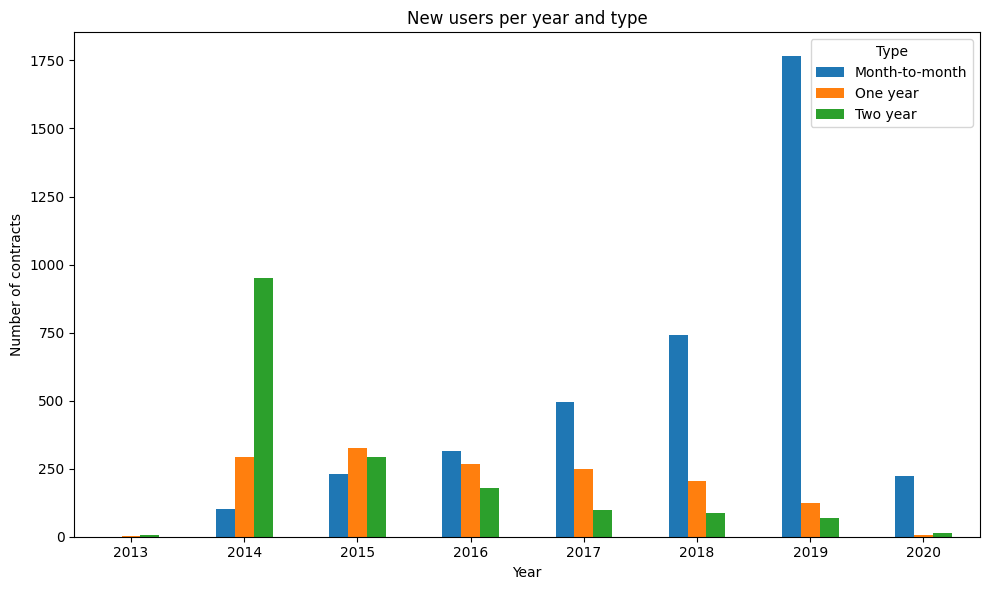

In [20]:
# Visualizar los usuarios nuevos por año y por tipo de contrato
bargraph_users(df_contract, ['begin_year', 'type'], 'Year', 'New users per year and type', 'Type')

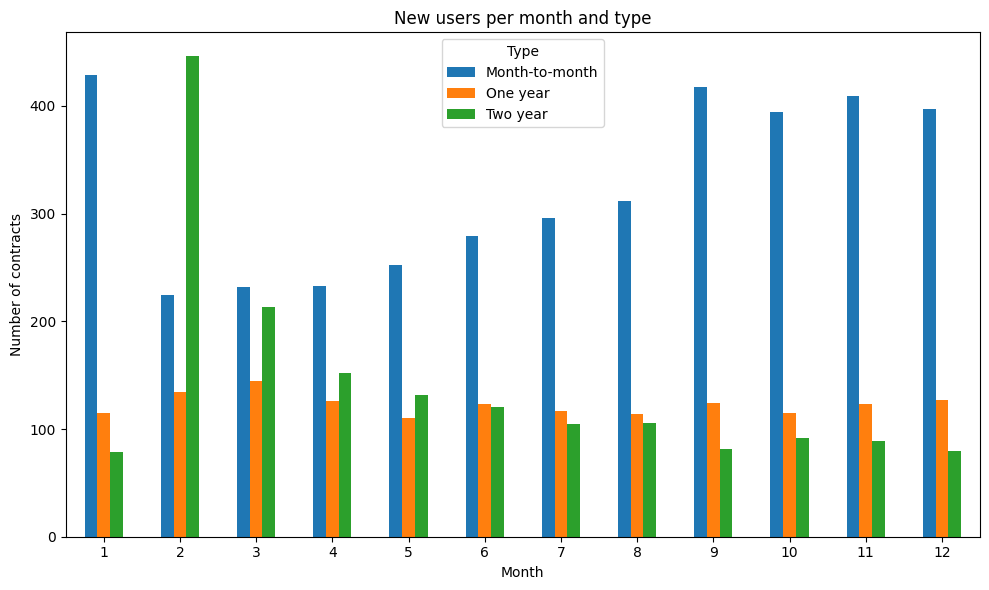

In [21]:
# Visualizar los usuarios nuevos por mes y por tipo de contrato
bargraph_users(df_contract, ['begin_month', 'type'], 'Month', 'New users per month and type', 'Type')

- 2014 y 2019 fueron años muy buenos en comparación al resto, parece que hay una tendencia positiva. 2020 solo hay datos de un mes, asi que no hay algo extraño. 
- Febrero es el mes donde mas usuarios se suman sobretodo para contrato de dos años, cual sera la razón?
- Los contratos a 2 años fueron en decremento mientras los contratos mes a mes se volvieron mas populares con tendencia positiva. 
- En 2019, 1750 contratos son mes a mes mientras que menos de 250 pertenecen a contratos de 1 o 2 años. 

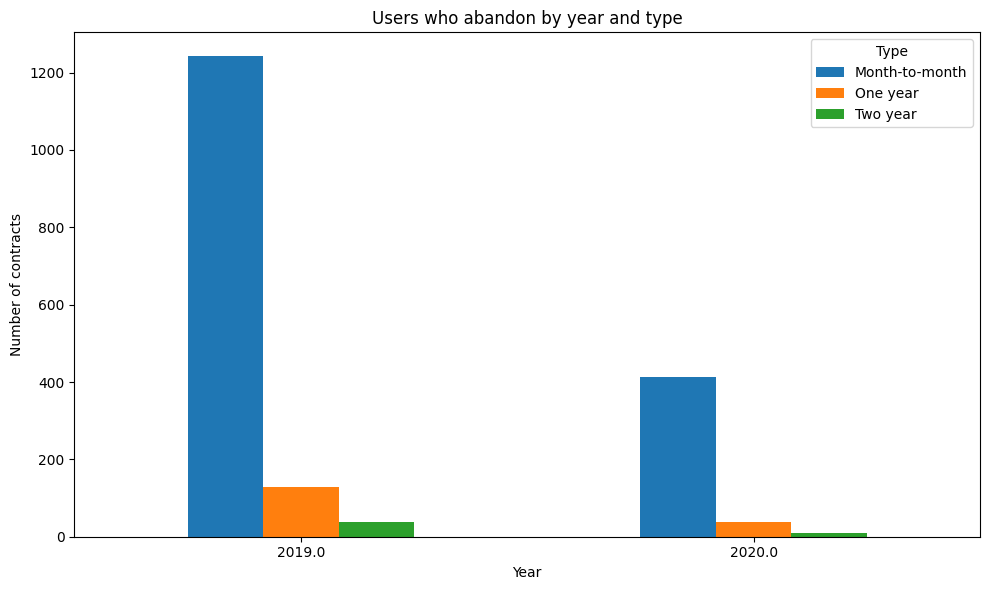

In [22]:
# Visualizar los usuarios que abandonaron por año
bargraph_users(df_contract, ['end_year', 'type'], 'Year', 'Users who abandon by year and type', 'Type')

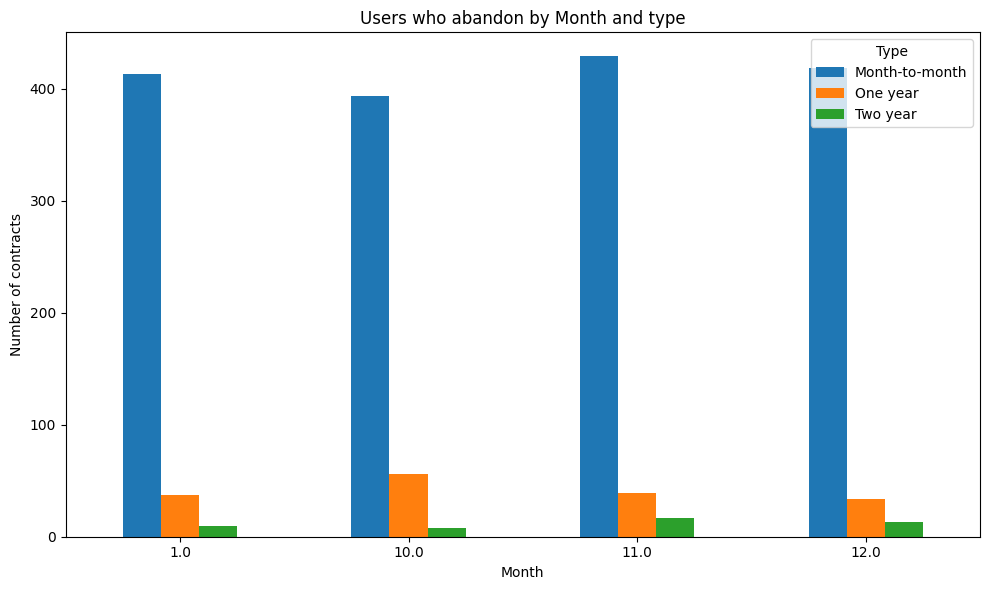

In [23]:
# Visualizar los usuarios que abandonaron por año
bargraph_users(df_contract, ['end_month', 'type'], 'Month', 'Users who abandon by Month and type', 'Type')

In [24]:
# Cuanto usuarios por año cancelaron el primer mes?
df_contract[(df_contract.is_active==False) & (df_contract.end_month==1)].end_year.value_counts()

end_year
2020.0    460
Name: count, dtype: int64

- Los usuarios estan abandonando en los últimos 2 años (2019 y 2020), algún cambio reciente?
- En general abandonan los últimos 4 meses. desde Octubre 2019 a Enero 2020. La mayoría son contratos de mes a mes.

In [25]:
# Cantidad de usuarios paperless_billing activos
df_contract.groupby('paperless_billing')['is_active'].sum()

paperless_billing
False    2403
True     2771
Name: is_active, dtype: int64

In [26]:
# Cantidad de usuarios paperless_billing
df_contract.paperless_billing.value_counts()

paperless_billing
True     4171
False    2872
Name: count, dtype: int64

In [27]:
# Cantidad de usuarios paperless_billing activos
df_contract.groupby('paperless_billing')['is_active'].sum() / df_contract.paperless_billing.value_counts() * 100

paperless_billing
False    83.669916
True     66.434908
dtype: float64

- Parece que los usuarios con paperless_billing en 'Si' tienen mayor abandono un 66.43% vs 83.66%.

In [28]:
# Reemplazar los valores ausentes de end_date por el vencimiento del contrato
df_contract['end_date_with_contract'] = df_contract.apply(real_end_date, axis=1)
df_contract

,customer_id,begin_date,end_date,type,payment_method,monthly_charges,total_charges,begin_month,begin_year,end_month,end_year,is_active,paperless_billing,end_date_with_contract
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Electronic check,29.85,29.85,1,2020,NaN,NaN,True,True,2020-02-01
1,5575-GNVDE,2017-04-01,NaT,One year,Mailed check,56.95,1889.50,4,2017,NaN,NaN,True,False,2020-04-01
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Mailed check,53.85,108.15,10,2019,12.0,2019.0,False,True,2019-12-01
3,7795-CFOCW,2016-05-01,NaT,One year,Bank transfer (automatic),42.30,1840.75,5,2016,NaN,NaN,True,False,2020-05-01
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Electronic check,70.70,151.65,9,2019,11.0,2019.0,False,True,2019-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Mailed check,84.80,1990.50,2,2018,NaN,NaN,True,True,2020-02-01
7039,2234-XADUH,2014-02-01,NaT,One year,Credit card (automatic),103.20,7362.90,2,2014,NaN,NaN,True,True,2020-02-01
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Electronic check,29.60,346.45,3,2019,NaN,NaN,True,True,2021-03-01
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Mailed check,74.40,306.60,7,2019,11.0,2019.0,False,True,2019-11-01


In [29]:
# Separar la columna end_date_with_contract de df_contract en año, mes
# Se hace de nuevo porque antes era para el análisis y ahora necesitamos eliminar los valores ausentes para el modelo.
df_contract = split_dates(df_contract, 'end_date_with_contract', 'end')
df_contract

,customer_id,begin_date,end_date,type,payment_method,monthly_charges,total_charges,begin_month,begin_year,end_month,end_year,is_active,paperless_billing,end_date_with_contract
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Electronic check,29.85,29.85,1,2020,2,2020,True,True,2020-02-01
1,5575-GNVDE,2017-04-01,NaT,One year,Mailed check,56.95,1889.50,4,2017,4,2020,True,False,2020-04-01
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Mailed check,53.85,108.15,10,2019,12,2019,False,True,2019-12-01
3,7795-CFOCW,2016-05-01,NaT,One year,Bank transfer (automatic),42.30,1840.75,5,2016,5,2020,True,False,2020-05-01
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Electronic check,70.70,151.65,9,2019,11,2019,False,True,2019-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Mailed check,84.80,1990.50,2,2018,2,2020,True,True,2020-02-01
7039,2234-XADUH,2014-02-01,NaT,One year,Credit card (automatic),103.20,7362.90,2,2014,2,2020,True,True,2020-02-01
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Electronic check,29.60,346.45,3,2019,3,2021,True,True,2021-03-01
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Mailed check,74.40,306.60,7,2019,11,2019,False,True,2019-11-01


In [30]:
# Crear una columna con los días activo en contract
df_contract['active_days'] = df_contract.apply(calculate_active_days, axis=1)
df_contract

,customer_id,begin_date,end_date,type,payment_method,monthly_charges,total_charges,begin_month,begin_year,end_month,end_year,is_active,paperless_billing,end_date_with_contract,active_days
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Electronic check,29.85,29.85,1,2020,2,2020,True,True,2020-02-01,0
1,5575-GNVDE,2017-04-01,NaT,One year,Mailed check,56.95,1889.50,4,2017,4,2020,True,False,2020-04-01,1005
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Mailed check,53.85,108.15,10,2019,12,2019,False,True,2019-12-01,61
3,7795-CFOCW,2016-05-01,NaT,One year,Bank transfer (automatic),42.30,1840.75,5,2016,5,2020,True,False,2020-05-01,1340
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Electronic check,70.70,151.65,9,2019,11,2019,False,True,2019-11-01,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Mailed check,84.80,1990.50,2,2018,2,2020,True,True,2020-02-01,699
7039,2234-XADUH,2014-02-01,NaT,One year,Credit card (automatic),103.20,7362.90,2,2014,2,2020,True,True,2020-02-01,2160
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Electronic check,29.60,346.45,3,2019,3,2021,True,True,2021-03-01,306
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Mailed check,74.40,306.60,7,2019,11,2019,False,True,2019-11-01,123


In [31]:
# Eliminar columnas innecesarias: being_date, end_date, end_date_with_contract
df_contract.drop(['begin_date', 'end_date', 'end_date_with_contract'], axis=1, inplace=True)
df_contract

,customer_id,type,payment_method,monthly_charges,total_charges,begin_month,begin_year,end_month,end_year,is_active,paperless_billing,active_days
0,7590-VHVEG,Month-to-month,Electronic check,29.85,29.85,1,2020,2,2020,True,True,0
1,5575-GNVDE,One year,Mailed check,56.95,1889.50,4,2017,4,2020,True,False,1005
2,3668-QPYBK,Month-to-month,Mailed check,53.85,108.15,10,2019,12,2019,False,True,61
3,7795-CFOCW,One year,Bank transfer (automatic),42.30,1840.75,5,2016,5,2020,True,False,1340
4,9237-HQITU,Month-to-month,Electronic check,70.70,151.65,9,2019,11,2019,False,True,61
...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,Mailed check,84.80,1990.50,2,2018,2,2020,True,True,699
7039,2234-XADUH,One year,Credit card (automatic),103.20,7362.90,2,2014,2,2020,True,True,2160
7040,4801-JZAZL,Month-to-month,Electronic check,29.60,346.45,3,2019,3,2021,True,True,306
7041,8361-LTMKD,Month-to-month,Mailed check,74.40,306.60,7,2019,11,2019,False,True,123


### <a id='toc1_5_4_'></a>[Personal](#toc0_)

In [32]:
df_personal.sample(10)

,customer_id,gender,senior_citizen,partner,dependents
4531,4910-AQFFX,Male,0,Yes,Yes
330,9385-EHGDO,Female,0,Yes,Yes
4482,6711-FLDFB,Female,0,No,No
6724,7359-SSBJK,Female,1,No,No
274,5940-AHUHD,Male,0,No,No
6340,3323-CPBWR,Male,0,No,No
5844,2905-KFQUV,Female,0,Yes,No
5034,9758-MFWGD,Female,1,Yes,Yes
3091,8189-DUKMV,Female,0,Yes,No
2173,2038-OEQZH,Male,0,No,No


In [33]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [34]:
df_personal.describe()

,senior_citizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


TODO:
- Cambiar las columnas gender, partner y dependents por bool.

In [35]:
# Cambiar las columnas gender, partner y dependents por bool. 
df_personal = column_to_bool(df_personal, ['gender', 'partner', 'dependents'])
df_personal = df_personal.rename(columns={'gender':'gender_male'}) 
df_personal

,customer_id,senior_citizen,gender_male,partner,dependents
0,7590-VHVEG,0,False,True,False
1,5575-GNVDE,0,True,False,False
2,3668-QPYBK,0,True,False,False
3,7795-CFOCW,0,True,False,False
4,9237-HQITU,0,False,False,False
...,...,...,...,...,...
7038,6840-RESVB,0,True,True,True
7039,2234-XADUH,0,False,True,True
7040,4801-JZAZL,0,False,True,True
7041,8361-LTMKD,1,True,True,False


In [36]:
# Juntar el dataset de contratos con el de personal para analizar las variables. 
df_telecom_clean = pd.merge(df_contract, df_personal, on='customer_id', how='outer')
df_telecom_clean

,customer_id,type,payment_method,monthly_charges,total_charges,begin_month,begin_year,end_month,end_year,is_active,paperless_billing,active_days,senior_citizen,gender_male,partner,dependents
0,0002-ORFBO,One year,Mailed check,65.60,593.30,5,2019,5,2020,True,True,245,0,False,True,True
1,0003-MKNFE,Month-to-month,Mailed check,59.90,542.40,5,2019,5,2021,True,False,245,0,True,False,False
2,0004-TLHLJ,Month-to-month,Electronic check,73.90,280.85,9,2019,1,2020,False,True,122,0,True,False,False
3,0011-IGKFF,Month-to-month,Electronic check,98.00,1237.85,12,2018,1,2020,False,True,396,1,True,True,False
4,0013-EXCHZ,Month-to-month,Mailed check,83.90,267.40,9,2019,12,2019,False,True,91,1,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,One year,Mailed check,55.15,742.90,1,2019,1,2020,True,False,365,0,False,False,False
7039,9992-RRAMN,Month-to-month,Electronic check,85.10,1873.70,2,2018,12,2019,False,True,668,0,True,True,False
7040,9992-UJOEL,Month-to-month,Mailed check,50.30,92.75,12,2019,12,2021,True,True,31,0,True,False,False
7041,9993-LHIEB,Two year,Mailed check,67.85,4627.65,7,2014,7,2021,True,False,2010,0,True,True,True


In [37]:
# Cuantas personas con depentiendes hay?
df_telecom_clean.dependents.value_counts()

dependents
False    4933
True     2110
Name: count, dtype: int64

In [38]:
# Cuantas personas con depentiendes son activas?
df_telecom_clean.groupby('dependents')['is_active'].sum()

dependents
False    3390
True     1784
Name: is_active, dtype: int64

In [39]:
# Porcentaje de activas y dependientes
df_telecom_clean.groupby('dependents')['is_active'].sum() / df_telecom_clean.dependents.value_counts() * 100

dependents
False    68.720860
True     84.549763
dtype: float64

Las personas sin dependientes suelen dejar el servicio mas que las que tienen dependientes.
68.72% de las personas con dependientes se mantienen activos, mientras que el 84.55% de las
personas sin dependientes se mantienen activos.

In [40]:
# Cuantas hombres hay?
df_telecom_clean.partner.value_counts()

partner
False    3641
True     3402
Name: count, dtype: int64

In [41]:
# Cuantas personas con depentiendes son activas?
df_telecom_clean.groupby('partner')['is_active'].sum()

partner
False    2441
True     2733
Name: is_active, dtype: int64

In [42]:
# Porcentaje de activas y dependientes
df_telecom_clean.groupby('partner')['is_active'].sum() / df_telecom_clean.partner.value_counts() * 100

partner
False    67.042021
True     80.335097
dtype: float64

Las personas con partner mantienen el servicio mas que las que no tienen. Las personas
con partner tienen un 80% de retención mientras que las que no tienen solo el 67%.

In [43]:
# Cuantas personas con partner hay?
df_telecom_clean.gender_male.value_counts()

gender_male
True     3555
False    3488
Name: count, dtype: int64

In [44]:
# Cuantas personas con depentiendes son activas?
df_telecom_clean.groupby('gender_male')['is_active'].sum()

gender_male
False    2549
True     2625
Name: is_active, dtype: int64

In [45]:
# Porcentaje de activas y dependientes
df_telecom_clean.groupby('gender_male')['is_active'].sum() / df_telecom_clean.gender_male.value_counts() * 100

gender_male
False    73.079128
True     73.839662
dtype: float64

No hay diferencia de género, ambos mantienen un porcentaje activo del 73%.

### <a id='toc1_5_5_'></a>[Internet](#toc0_)

In [46]:
df_internet.sample(10)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
578,4952-YSOGZ,Fiber optic,No,No,No,No,No,Yes
4230,9715-WZCLW,Fiber optic,Yes,No,No,No,Yes,Yes
4331,5044-LRQAQ,Fiber optic,No,No,No,No,No,No
4857,2330-PQGDQ,Fiber optic,No,Yes,No,Yes,No,No
2139,4236-UJPWO,DSL,No,No,No,No,No,No
3003,7714-YXSMB,Fiber optic,No,No,Yes,No,Yes,Yes
152,2472-OVKUP,Fiber optic,No,Yes,Yes,No,No,Yes
2279,9619-GSATL,DSL,No,Yes,No,Yes,No,No
4996,7921-BEPCI,DSL,Yes,Yes,No,No,No,No
662,3643-AHCFP,Fiber optic,No,No,No,No,Yes,Yes


In [47]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [48]:
df_internet.describe()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


TODO:
- Cambiar todas las columnas al tipo bool.
- Encontrar grupos de servicios.

In [49]:
# Cambiar las columnas al tipo bool
df_internet = column_to_bool(df_internet, ['internet_service', 'online_security', 'online_backup', 'device_protection',
                                           'tech_support', 'streaming_tv', 'streaming_movies'])
df_internet = df_internet.rename(columns={'internet_service':'internet_fiber_optic'})
df_internet

,customer_id,internet_fiber_optic,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,False,False,True,False,False,False,False
1,5575-GNVDE,False,True,False,True,False,False,False
2,3668-QPYBK,False,True,True,False,False,False,False
3,7795-CFOCW,False,True,False,True,True,False,False
4,9237-HQITU,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,False,True,False,True,True,True,True
5513,2234-XADUH,True,False,True,True,False,True,True
5514,4801-JZAZL,False,True,False,False,False,False,False
5515,8361-LTMKD,True,False,False,False,False,False,False


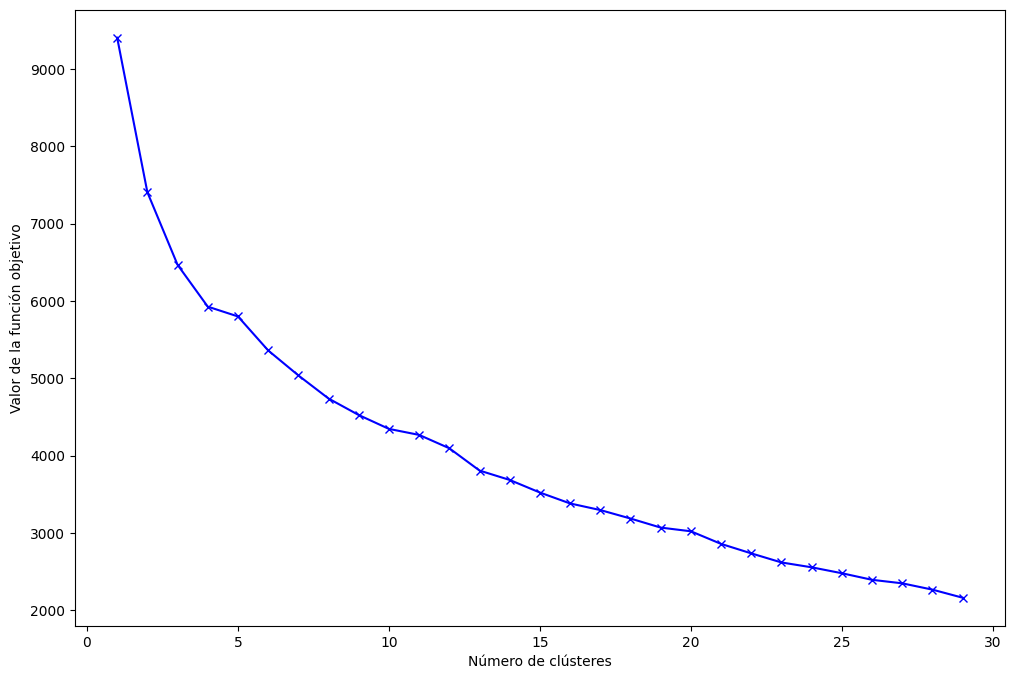

In [50]:
# Encontrar el número de clusters óptimo
distortion = []
K = range(1, 30)
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(df_internet.drop('customer_id', axis=1))
    distortion.append(model.inertia_) 

plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Número de clústeres')
plt.ylabel('Valor de la función objetivo')
plt.show() 

Parece haber demasiadas combinaciones. Se descargara como característica el etiquetado de grupos.

In [51]:
# Agregar internet al dataframe combinado
df_telecom_clean = pd.merge(df_telecom_clean, df_internet, on='customer_id', how='outer')
df_telecom_clean

,customer_id,type,payment_method,monthly_charges,total_charges,begin_month,begin_year,end_month,end_year,is_active,...,gender_male,partner,dependents,internet_fiber_optic,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,0002-ORFBO,One year,Mailed check,65.60,593.30,5,2019,5,2020,True,...,False,True,True,False,False,True,False,True,True,False
1,0003-MKNFE,Month-to-month,Mailed check,59.90,542.40,5,2019,5,2021,True,...,True,False,False,False,False,False,False,False,False,True
2,0004-TLHLJ,Month-to-month,Electronic check,73.90,280.85,9,2019,1,2020,False,...,True,False,False,True,False,False,True,False,False,False
3,0011-IGKFF,Month-to-month,Electronic check,98.00,1237.85,12,2018,1,2020,False,...,True,True,False,True,False,True,True,False,True,True
4,0013-EXCHZ,Month-to-month,Mailed check,83.90,267.40,9,2019,12,2019,False,...,False,True,False,True,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,One year,Mailed check,55.15,742.90,1,2019,1,2020,True,...,False,False,False,False,True,False,False,True,False,False
7039,9992-RRAMN,Month-to-month,Electronic check,85.10,1873.70,2,2018,12,2019,False,...,True,True,False,True,False,False,False,False,False,True
7040,9992-UJOEL,Month-to-month,Mailed check,50.30,92.75,12,2019,12,2021,True,...,True,False,False,False,False,True,False,False,False,False
7041,9993-LHIEB,Two year,Mailed check,67.85,4627.65,7,2014,7,2021,True,...,True,True,True,False,True,False,True,True,False,True


In [52]:
# Ver los valores ausentes
df_telecom_clean.isna().sum()

customer_id                0
type                       0
payment_method             0
monthly_charges            0
total_charges              0
begin_month                0
begin_year                 0
end_month                  0
end_year                   0
is_active                  0
paperless_billing          0
active_days                0
senior_citizen             0
gender_male                0
partner                    0
dependents                 0
internet_fiber_optic    1526
online_security         1526
online_backup           1526
device_protection       1526
tech_support            1526
streaming_tv            1526
streaming_movies        1526
dtype: int64

Estos valorse se generaron al juntar el dataframe, simplemente se cambiaran por el valor False al mezclar todos los dataframe. Probablemente algunos usuarios no tienen el servicio de internet.

In [53]:
# Ver el porcentaje de activos por servicio de internet
columns = ['internet_fiber_optic', 'online_security', 'online_backup', 'device_protection',
           'tech_support', 'streaming_tv', 'streaming_movies']

active_users = []
for col in columns:
    n_users = df_telecom_clean[col].sum()
    n_users_active = len(df_telecom_clean[(df_telecom_clean[col]==True) & (df_telecom_clean['is_active']==True)])
    active_percent_per_user = n_users_active / n_users * 100
    active_users.append(active_percent_per_user)

active_users

[58.10723514211886,
 85.38880633977216,
 78.46850555784273,
 77.49793559042114,
 84.83365949119374,
 69.9298115995567,
 70.05856515373353]

- Los usuarios con fibra optica, son los que menos renovaron el servicio, mantiene solo un 58.1% de usuarios activos. 
- Los usuarios que mas mantienen el servicio son los que tienen seguridad en linea con un 85% de retención.

### <a id='toc1_5_6_'></a>[Phone](#toc0_)

In [54]:
df_phone

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [55]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [56]:
df_phone.describe()

,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


TODO:
- Cambiar la columna multiple_lines a tipo bool. 

In [57]:
# Cambiar la columna multiple_lines a tipo bool. 
df_phone = column_to_bool(df_phone, ['multiple_lines'])
df_phone

,customer_id,multiple_lines
0,5575-GNVDE,False
1,3668-QPYBK,False
2,9237-HQITU,False
3,9305-CDSKC,True
4,1452-KIOVK,True
...,...,...
6356,2569-WGERO,False
6357,6840-RESVB,True
6358,2234-XADUH,True
6359,8361-LTMKD,True


In [58]:
# Añadir phone al dataframe combinado
df_telecom_clean = pd.merge(df_telecom_clean, df_phone, on='customer_id', how='outer')
df_telecom_clean

,customer_id,type,payment_method,monthly_charges,total_charges,begin_month,begin_year,end_month,end_year,is_active,...,partner,dependents,internet_fiber_optic,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,0002-ORFBO,One year,Mailed check,65.60,593.30,5,2019,5,2020,True,...,True,True,False,False,True,False,True,True,False,False
1,0003-MKNFE,Month-to-month,Mailed check,59.90,542.40,5,2019,5,2021,True,...,False,False,False,False,False,False,False,False,True,True
2,0004-TLHLJ,Month-to-month,Electronic check,73.90,280.85,9,2019,1,2020,False,...,False,False,True,False,False,True,False,False,False,False
3,0011-IGKFF,Month-to-month,Electronic check,98.00,1237.85,12,2018,1,2020,False,...,True,False,True,False,True,True,False,True,True,False
4,0013-EXCHZ,Month-to-month,Mailed check,83.90,267.40,9,2019,12,2019,False,...,True,False,True,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,One year,Mailed check,55.15,742.90,1,2019,1,2020,True,...,False,False,False,True,False,False,True,False,False,False
7039,9992-RRAMN,Month-to-month,Electronic check,85.10,1873.70,2,2018,12,2019,False,...,True,False,True,False,False,False,False,False,True,True
7040,9992-UJOEL,Month-to-month,Mailed check,50.30,92.75,12,2019,12,2021,True,...,False,False,False,False,True,False,False,False,False,False
7041,9993-LHIEB,Two year,Mailed check,67.85,4627.65,7,2014,7,2021,True,...,True,True,False,True,False,True,True,False,True,False


In [59]:
# Ver el porcentaje de retención de activos con multilinea
df_telecom_clean[(df_telecom_clean['multiple_lines']==True) & (df_telecom_clean['is_active']==True)]['is_active'].sum() / df_phone['multiple_lines'].sum() * 100

71.3901043419724

In [60]:
# Ver el porcentaje de retención de activos sin multilinea
df_telecom_clean[(df_telecom_clean['multiple_lines']==False) & (df_telecom_clean['is_active']==True)]['is_active'].sum() / df_telecom_clean['multiple_lines'].sum() * 100

85.52675866711546

Hay mayor porcentaje de retención para los que no tienen multilinea (85.5% siguen activos) mientras que para los que tienen multilinea es del 71.4%.

In [61]:
# Rellenar valores ausentes provocados por el merge. Se rellenaran con false.
df_telecom_clean.fillna(False, inplace=True)
df_telecom_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           7043 non-null   object 
 1   type                  7043 non-null   object 
 2   payment_method        7043 non-null   object 
 3   monthly_charges       7043 non-null   float64
 4   total_charges         7043 non-null   float64
 5   begin_month           7043 non-null   int32  
 6   begin_year            7043 non-null   int32  
 7   end_month             7043 non-null   int32  
 8   end_year              7043 non-null   int32  
 9   is_active             7043 non-null   bool   
 10  paperless_billing     7043 non-null   bool   
 11  active_days           7043 non-null   int64  
 12  senior_citizen        7043 non-null   int64  
 13  gender_male           7043 non-null   bool   
 14  partner               7043 non-null   bool   
 15  dependents           

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [62]:
# Eliminar la columna customer_id que no servira para el modelo
df_telecom_clean.drop('customer_id', axis=1, inplace=True)

# Eliminar begin_month y begin_year, para quedarme con active_days
df_telecom_clean.drop(['begin_year', 'begin_month', 'end_month', 'end_year'], axis=1, inplace=True)

df_telecom_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  7043 non-null   object 
 1   payment_method        7043 non-null   object 
 2   monthly_charges       7043 non-null   float64
 3   total_charges         7043 non-null   float64
 4   is_active             7043 non-null   bool   
 5   paperless_billing     7043 non-null   bool   
 6   active_days           7043 non-null   int64  
 7   senior_citizen        7043 non-null   int64  
 8   gender_male           7043 non-null   bool   
 9   partner               7043 non-null   bool   
 10  dependents            7043 non-null   bool   
 11  internet_fiber_optic  7043 non-null   bool   
 12  online_security       7043 non-null   bool   
 13  online_backup         7043 non-null   bool   
 14  device_protection     7043 non-null   bool   
 15  tech_support         

## <a id='toc1_6_'></a>[Preparación de los datos](#toc0_)

In [63]:
# Definir las características y el objetivo
features = df_telecom_clean.drop('is_active', axis=1)
target = df_telecom_clean['is_active']

### <a id='toc1_6_1_'></a>[Balanceo por sobremuestreo](#toc0_)

In [64]:
# Aplicar sobremuestreo para balancear el objetivo
over_sampler = RandomOverSampler(random_state=54321)
features_oversampled, target_oversampled = over_sampler.fit_resample(features, target)

### <a id='toc1_6_2_'></a>[División en conjunto prueba y entrenamiento](#toc0_)

In [65]:
# Dividir el dataframe en entrenamiento y prueba
features_train, features_test, target_train, target_test = train_test_split(
    features_oversampled, target_oversampled, test_size=0.2, random_state=54321
)

### <a id='toc1_6_3_'></a>[One Hot-Encoding](#toc0_)

In [66]:
# payment_method a ohe
features_train_encoded = pd.get_dummies(features_train, columns=['payment_method'])
features_test_encoded = pd.get_dummies(features_test, columns=['payment_method'])

In [67]:
# Visualizar el dataframe
features_train_encoded.head()

,type,monthly_charges,total_charges,paperless_billing,active_days,senior_citizen,gender_male,partner,dependents,internet_fiber_optic,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check
4350,Month-to-month,35.20,607.30,True,518,0,False,False,False,False,...,False,True,True,False,False,False,False,False,True,False
7787,Month-to-month,20.20,20.20,True,30,0,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6602,Two year,82.65,5919.35,True,2160,0,False,True,False,False,...,True,True,False,True,True,True,False,True,False,False
322,Two year,24.25,1784.50,False,2160,0,False,True,True,False,...,False,False,False,False,False,True,False,True,False,False
4383,Two year,55.50,2627.35,False,1430,0,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False


### <a id='toc1_6_4_'></a>[Label Encoder](#toc0_)

In [68]:
# type a label encoding
label_encoder = LabelEncoder()
features_train_encoded['type'] = label_encoder.fit_transform(features_train['type'])
features_test_encoded['type'] = label_encoder.transform(features_test['type'])

In [69]:
features_train_encoded.head()

,type,monthly_charges,total_charges,paperless_billing,active_days,senior_citizen,gender_male,partner,dependents,internet_fiber_optic,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check
4350,0,35.20,607.30,True,518,0,False,False,False,False,...,False,True,True,False,False,False,False,False,True,False
7787,0,20.20,20.20,True,30,0,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6602,2,82.65,5919.35,True,2160,0,False,True,False,False,...,True,True,False,True,True,True,False,True,False,False
322,2,24.25,1784.50,False,2160,0,False,True,True,False,...,False,False,False,False,False,True,False,True,False,False
4383,2,55.50,2627.35,False,1430,0,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False


### <a id='toc1_6_5_'></a>[Escalado de datos (MixMaxScaler)](#toc0_)

In [70]:
# Escalar las características de prueba y entrenamiento
scaler = MinMaxScaler()
features_train_encoded_scaled = features_train_encoded.copy()
features_test_encoded_scaled = features_test_encoded.copy()
columns_to_scale = ['type', 'monthly_charges', 'total_charges','active_days']
features_train_encoded_scaled[columns_to_scale] = scaler.fit_transform(features_train_encoded[columns_to_scale])
features_test_encoded_scaled[columns_to_scale] = scaler.transform(features_test_encoded[columns_to_scale])

## <a id='toc1_7_'></a>[Feature engineering](#toc0_)

### <a id='toc1_7_1_'></a>[Correlación de características númericas](#toc0_)

In [71]:
# Ver la correlación 
pd.concat([features_train_encoded_scaled[columns_to_scale], target_train], axis=1).corr()

,type,monthly_charges,total_charges,active_days,is_active
type,1.000000,-0.089051,0.472101,0.675169,0.495287
monthly_charges,-0.089051,1.000000,0.584260,0.226718,-0.222864
total_charges,0.472101,0.584260,1.000000,0.848601,0.245502
active_days,0.675169,0.226718,0.848601,1.000000,0.390393
is_active,0.495287,-0.222864,0.245502,0.390393,1.000000


1) Correlaciones débiles con is_active (menores a 0.3)
   - monthly_charges tiene una correlación negativa del 0.22.
   - total_changes tiene una correlación positiva del 0.23. (Entre mas alto sea el cargo por mes mas bandonan, pero si el cargo total es grande se quedan?)

2) Correlaciones fuertes sobre is_active
   - end_year tiene una correlción positiva fuerte del 0.75.
   - type tiene una correlación positiva fuerte del 0.48.

In [72]:
# Extraer el nombre de las columnas con tipo bool y string
cols_bool = df_telecom_clean.columns[df_telecom_clean.dtypes == bool]
cols_str = df_telecom_clean.columns[df_telecom_clean.dtypes == 'O']
cols_combined = cols_bool.append(cols_str)
cols_combined

Index(['is_active', 'paperless_billing', 'gender_male', 'partner',
       'dependents', 'internet_fiber_optic', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines', 'type', 'payment_method'],
      dtype='object')

In [73]:
# Realizar una tabla de contingencia para cada combinación de variables categoricas
for combination in combinations(cols_combined, 2):
    contingency_table = pd.crosstab(df_telecom_clean[combination[0]], df_telecom_clean[combination[1]])
    chi2, p, _, _ = st.chi2_contingency(contingency_table)
    
    # Ignorar las las combinaciones fuera de mi hipótesis
    # H0: No hay asociación entre las variables categoricas.
    # H1: Hay asociación entre las variables categoricas.
    # Nivel de significancia 
    alpha = 0.05
    if p > alpha:
        print(f"Tabla de Contingencia para {combination}:")
        print(contingency_table)
        print("\nTest Chi-Cuadrado:")
        print("Estadístico Chi-Cuadrado:", chi2)
        print("Valor p:", p)
        print("--------------------------------------------------")
        print("No hay asociación entre las variables")

Tabla de Contingencia para ('is_active', 'gender_male'):
gender_male  False  True 
is_active                
False          939    930
True          2549   2625

Test Chi-Cuadrado:
Estadístico Chi-Cuadrado: 0.4840828822091383
Valor p: 0.48657873605618596
--------------------------------------------------
No hay asociación entre las variables
Tabla de Contingencia para ('paperless_billing', 'gender_male'):
gender_male        False  True 
paperless_billing              
False               1402   1470
True                2086   2085

Test Chi-Cuadrado:
Estadístico Chi-Cuadrado: 0.9257356216945363
Valor p: 0.3359734782280932
--------------------------------------------------
No hay asociación entre las variables
Tabla de Contingencia para ('paperless_billing', 'partner'):
partner            False  True 
paperless_billing              
False               1459   1413
True                2182   1989

Test Chi-Cuadrado:
Estadístico Chi-Cuadrado: 1.4987222611381033
Valor p: 0.2208680676177213

- Resultados: El género no tiene asociación con el objetivo y con muchas de las otras variables. Por esta razón sera descartda. 

### <a id='toc1_7_2_'></a>[Boruta](#toc0_)

In [74]:
# Se utilizara un modelo de bosque aletorio como base para el algoritmo Boruta

# Inicializar el modelo base
rf = RandomForestClassifier(random_state=54321)

# Inicializar Boruta
boruta_selector = BorutaPy(estimator=rf, n_estimators='auto', verbose=2)

# Ajustar Boruta al conjunto de datos
boruta_selector.fit(features_train_encoded.values, target_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	16
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	17



BorutaPy(estimator=RandomForestClassifier(n_estimators=31,
                                          random_state=RandomState(MT19937) at 0x208D7C7B640),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x208D7C7B640, verbose=2)

In [76]:
# Seleccionar las características mas relevantes de boruta
boruta_features = features_train_encoded.columns[boruta_selector.support_]
boruta_features

Index(['type', 'monthly_charges', 'total_charges', 'active_days'], dtype='object')

In [77]:
# Ver las características rechazadas
features_train_encoded.columns[~boruta_selector.support_]

Index(['paperless_billing', 'senior_citizen', 'gender_male', 'partner',
       'dependents', 'internet_fiber_optic', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines',
       'payment_method_Bank transfer (automatic)',
       'payment_method_Credit card (automatic)',
       'payment_method_Electronic check', 'payment_method_Mailed check'],
      dtype='object')

Boruta selecciono 10 de 24 columnas. Entre ellas rechzo la columna de género. Toma como importantes el tipo de contrto, los cargos por mes y totales, la fecha de inicio y la fecha de fin, los días activo, si el cliente tiene fibra óptica y el método de pago electronico.

### <a id='toc1_7_3_'></a>[SHAP](#toc0_)

100%|===================| 4127/4140 [03:56<00:00]        

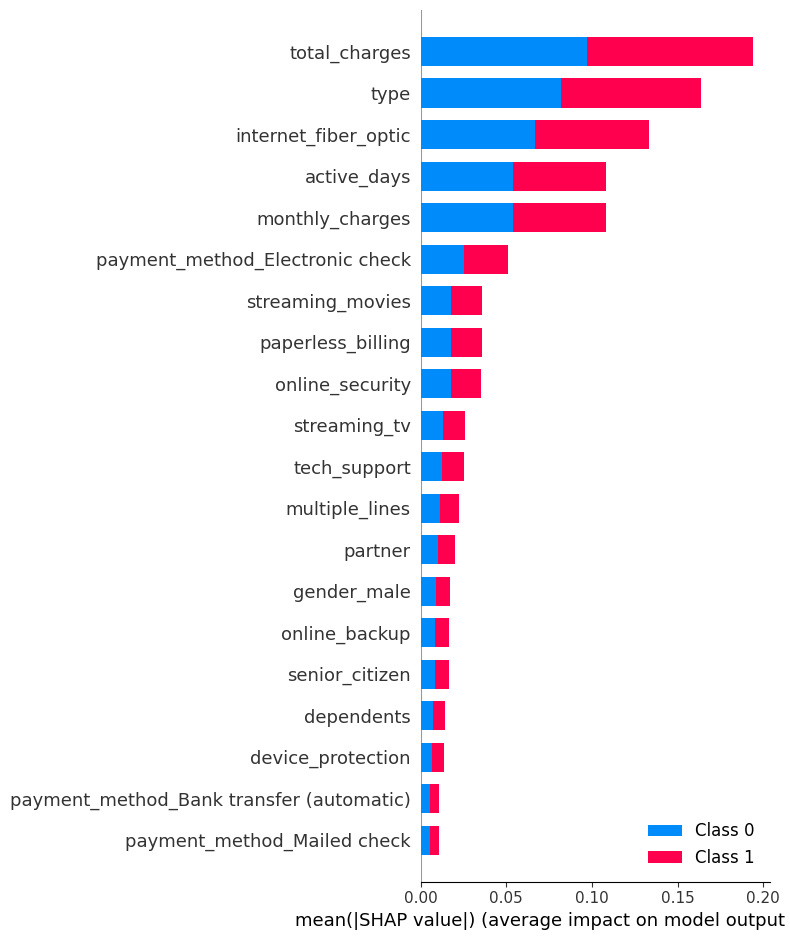

In [78]:
# Inicializar el modelo base (bosque aleatorio)
model = RandomForestClassifier(n_estimators=100, random_state=54321)
model.fit(features_train_encoded.astype(float), target_train)

# Calcular los valores SHAP para explicar las predicciones del modelo
explainer = shap.Explainer(model, features_train_encoded.astype(float))
shap_values = explainer.shap_values(features_test_encoded.astype(float), check_additivity=False)

# Mostrar el resumen de los valores SHAP
shap.summary_plot(shap_values, features_test_encoded.astype(float))

- Parece que end_year es la característica que mas afecta. 
- El tipo de contrato, total_charges, días activos, fechas de inicio y fin. Son características que ya habiamos obtenido con Boruta. 
- Curiosamente el método de pago electronico vuelve a aparecer, tenia un porcentaje de activos del 54.71%, algo pasara con ese método de pago?

### <a id='toc1_7_4_'></a>[Regularización del Lasso](#toc0_)

In [79]:
# Crear y entrenar el modelo de regresión Lasso
lasso = Lasso(alpha=0.0005)  # alpha es el parámetro de regularización
lasso.fit(features_train_encoded_scaled, target_train)

# Realizar predicciones en el conjunto de prueba
predicts = lasso.predict(features_test_encoded_scaled)

# Calcular la raíz del error cuadrático medio
rmse = mean_squared_error(target_test, predicts) ** 0.5
print("Raíz del error cuadrático medio:", rmse)

# Mostrar los coeficientes del modelo
print("Coeficientes del modelo:", lasso.coef_)

for index in range(len(lasso.coef_)):
    if abs(lasso.coef_[index]) != 0:
        print("Coeficiente: ", lasso.coef_[index])
        print("Columnas: ", features_test_encoded_scaled.columns[index])

Raíz del error cuadrático medio: 0.4137256628921231
Coeficientes del modelo: [ 0.31693751 -0.35973685  0.4750321  -0.06083391  0.01351375 -0.04371606
 -0.          0.031974    0.0116877  -0.10254018  0.06788557  0.02116144
  0.0045555   0.03475406 -0.01979125 -0.03679467 -0.         -0.
  0.00513387 -0.08508551  0.00331459]
Coeficiente:  0.3169375071265833
Columnas:  type
Coeficiente:  -0.35973685374918407
Columnas:  monthly_charges
Coeficiente:  0.4750320989962022
Columnas:  total_charges
Coeficiente:  -0.0608339127583026
Columnas:  paperless_billing
Coeficiente:  0.013513751213790696
Columnas:  active_days
Coeficiente:  -0.043716061256209464
Columnas:  senior_citizen
Coeficiente:  0.031973996493972937
Columnas:  partner
Coeficiente:  0.01168769525985547
Columnas:  dependents
Coeficiente:  -0.10254018350556729
Columnas:  internet_fiber_optic
Coeficiente:  0.0678855682956291
Columnas:  online_security
Coeficiente:  0.021161438611246614
Columnas:  online_backup
Coeficiente:  0.004555496

Columnas con retención de activos (entre mas alto el valor, los usuarios se mantienen con el servicio):
- Tipo de contrato, si es a largo plazo, mayor retención hay.
- total_charges. 
- end_month.
- end_year. 
- dependents.
- online_security
- teach_support

Columnas con abandono (entre mas alto el valor de la columna mayor abandono hay):
- active_days, entre mas tiempo tenga, mas probabilidad hay de abandono. 
- montly_charges.
- senior_citizen.
- partner.
- internet_fiber_optic
- streaming_tv
- streaming_movies
- multiple_lines
- payment_method_Electronic

### <a id='toc1_7_5_'></a>[Selección de características](#toc0_)

In [80]:
# Se va a filtrar el dataset con las columnas obtenidas por Boruta
features_train_encoded = features_train_encoded[boruta_features]
features_test_encoded = features_test_encoded[boruta_features]
features_train_encoded_scaled = features_train_encoded_scaled[boruta_features]
features_test_encoded_scaled = features_test_encoded_scaled[boruta_features]
features_train_encoded

,type,monthly_charges,total_charges,active_days
4350,0,35.20,607.30,518
7787,0,20.20,20.20,30
6602,2,82.65,5919.35,2160
322,2,24.25,1784.50,2160
4383,2,55.50,2627.35,1430
...,...,...,...,...
1174,0,94.25,6081.40,1918
10212,0,50.15,762.25,487
4192,0,20.05,42.70,31
4746,0,85.50,4042.30,1430


In [81]:
features_test_encoded

,type,monthly_charges,total_charges,active_days
157,0,75.20,1929.35,822
5580,0,68.65,1493.20,610
9481,0,70.00,2416.10,1036
6682,1,19.20,161.95,214
3126,0,55.30,196.15,91
...,...,...,...,...
6910,1,20.20,845.60,1370
7226,0,24.75,24.75,30
4375,2,20.50,759.35,1036
4355,2,20.05,1198.05,1918


## <a id='toc1_8_'></a>[Modelado](#toc0_)
### <a id='toc1_8_1_'></a>[Dummy model](#toc0_)

          train  test
Accuracy   0.50  0.50
F1         0.67  0.66
APS        0.50  0.50
ROC AUC    0.50  0.50


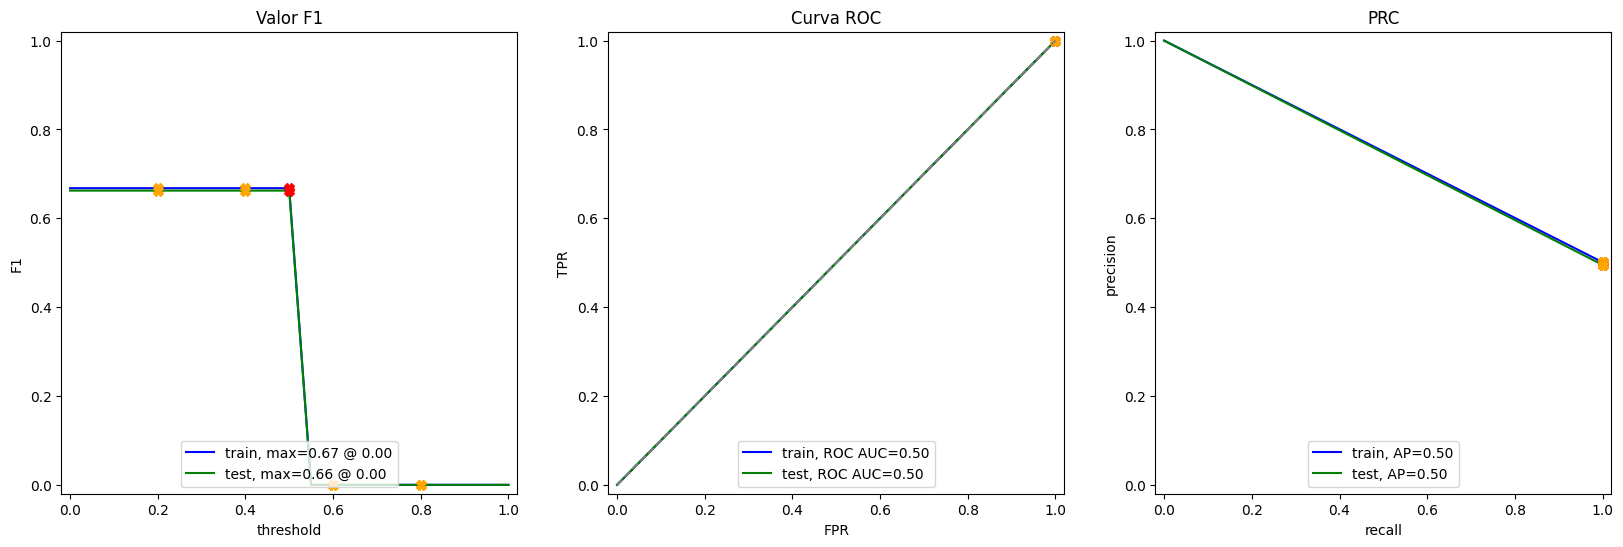

In [93]:
# Definir el modelo y ajustar
model = DummyClassifier()
model.fit(features_train, target_train)

# Evaluar el modelo para Exactitud, F1, APS, ROC-AUC
evaluate_model(model, features_train, target_train, features_test, target_test)

### <a id='toc1_8_2_'></a>[Logistic Regression model](#toc0_)

          train  test
Accuracy   0.74  0.73
F1         0.73  0.72
APS        0.84  0.82
ROC AUC    0.83  0.81


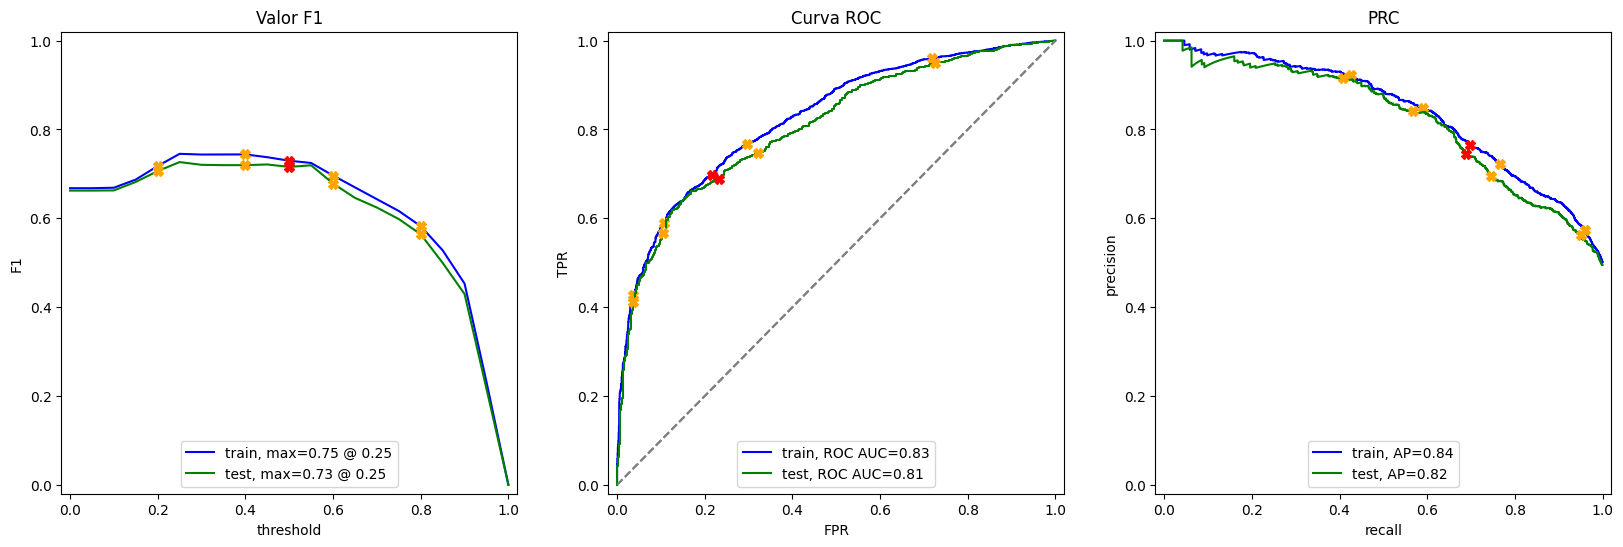

In [95]:
# Definir el modelo y ajustar
model = LogisticRegression()
model.fit(features_train_encoded_scaled, target_train)

# Evaluar el modelo para Exactitud, F1, APS, ROC-AUC
evaluate_model(model, features_train_encoded_scaled, target_train, features_test_encoded_scaled, target_test)

### <a id='toc1_8_3_'></a>[Catboost model](#toc0_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 0.6293835	total: 4.64ms	remaining: 2.32s
100:	learn: 0.3460275	total: 477ms	remaining: 1.89s
200:	learn: 0.2718917	total: 1.03s	remaining: 1.54s


300:	learn: 0.2243005	total: 1.62s	remaining: 1.07s
400:	learn: 0.1869335	total: 2.17s	remaining: 536ms
499:	learn: 0.1580845	total: 2.71s	remaining: 0us
[CV] END depth=6, iterations=500, l2_leaf_reg=1, learning_rate=0.1, verbose_eval=100; total time=   2.8s
0:	learn: 0.6320194	total: 5.16ms	remaining: 2.58s
100:	learn: 0.3416567	total: 574ms	remaining: 2.27s
200:	learn: 0.2647338	total: 1.17s	remaining: 1.75s
300:	learn: 0.2144426	total: 1.79s	remaining: 1.18s
400:	learn: 0.1803890	total: 2.39s	remaining: 591ms
499:	learn: 0.1538097	total: 2.93s	remaining: 0us
[CV] END depth=6, iterations=500, l2_leaf_reg=1, learning_rate=0.1, verbose_eval=100; total time=   3.0s
0:	learn: 0.6285686	total: 4.58ms	remaining: 2.29s
100:	learn: 0.3391082	total: 570ms	remaining: 2.25s
200:	learn: 0.2621741	total: 1.2s	remaining: 1.78s
300:	learn: 0.2132655	total: 1.83s	remaining: 1.21s
400:	learn: 0.1791759	total: 2.41s	remaining: 595ms
499:	learn: 0.1536613	total: 3s	remaining: 0us
[CV] END depth=6, iter

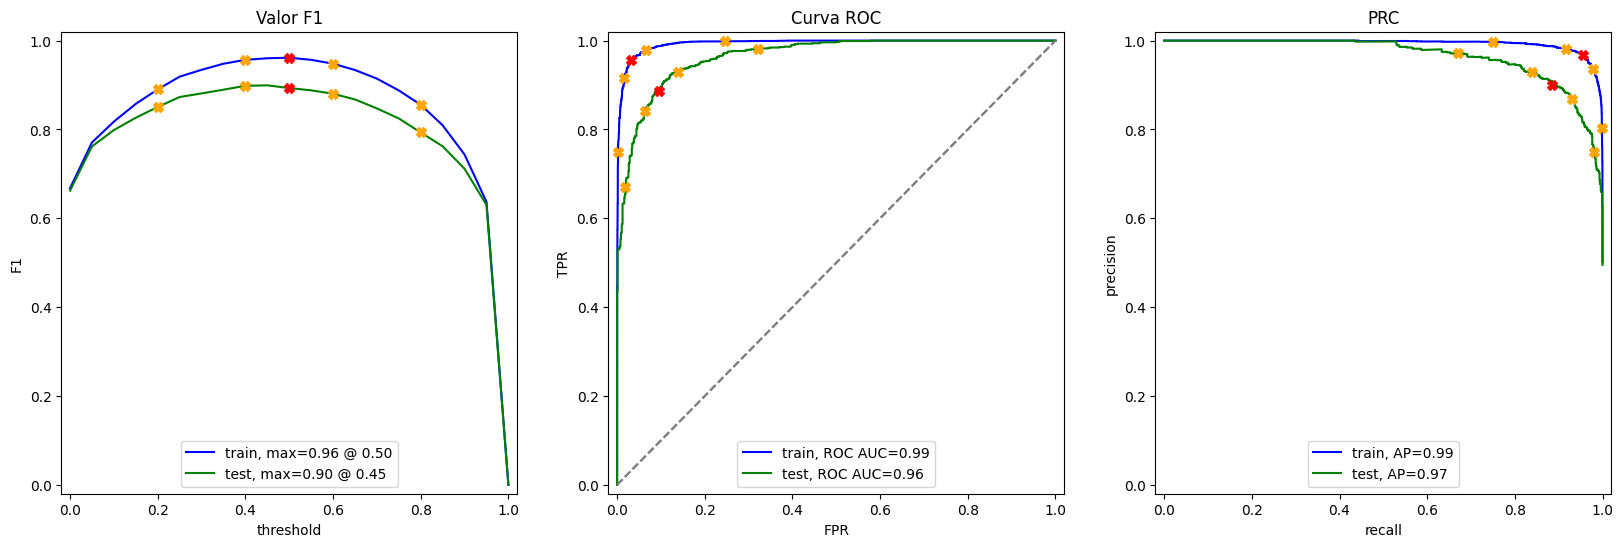

In [103]:
# Definir la grilla de hiperparámetros para la búsqueda aleatoria
# Nota los hiperaparámetros puestos a continuación son los obtenidos en la búsqueda
# para minimizar el tiempo de entrenamiento
param_grid = {
    'learning_rate': [0.1],
    'depth': [6],
    'l2_leaf_reg': [1],
    'iterations': [500],
    'verbose_eval': [100]
}

# Métricas de evaluación
scoring = {'ROC-AUC': 'roc_auc', 'F1': 'f1', 'Accuracy': 'accuracy'}

# Definir el modelo catboost
catboost = CatBoostClassifier()

# Realizar la búsqueda aleatoria con validación cruzada
grid_search = GridSearchCV(estimator=catboost, param_grid=param_grid, cv=5, scoring=scoring, refit='ROC-AUC', verbose=2)
grid_search.fit(features_train_encoded, target_train.astype(int))

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros encontrados:", best_params)

# Evaluar el mejor modelo para Exactitud, F1, APS, ROC-AUC
best_model = grid_search.best_estimator_
evaluate_model(best_model, features_train_encoded, target_train, features_test_encoded, target_test)

Mejores hiperparámetros encontrados para Catboost: ('depth': 6, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.1)
- Tiempo de ejecución: 5 min 33 seg.
- ROC-AUC: 0.9106641371892925
- F1-score: 0.9111857897263563
- Accuracy: 0.9106280193236715

### <a id='toc1_8_4_'></a>[LightGBM model](#toc0_)

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Number of positive: 3319, number of negative: 3303
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 6622, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501208 -> initscore=0.004832
[LightGBM] [Info] Start training from score 0.004832
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Number of positive: 3319, number of negative: 3303
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set

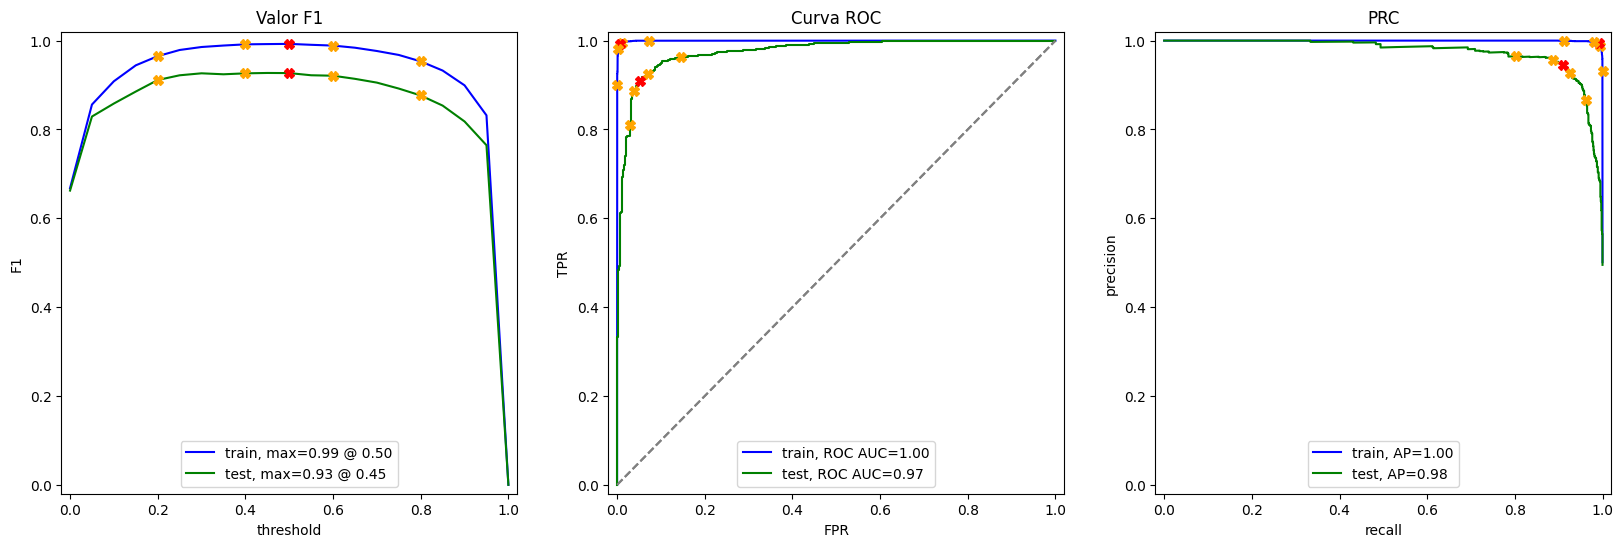

In [104]:
# Definir la grilla de hiperparámetros para la búsqueda en cuadrícula
# Nota los hiperaparámetros puestos a continuación son los obtenidos en la búsqueda
# para minimizar el tiempo de entrenamiento
param_grid = {
    'objective': ['binary'],
    'metric': ['auc'],
    'learning_rate': [0.1],
    'max_depth': [24],
    'reg_lambda': [1],
    'n_estimators': [1000],
    'num_leaves': [24],
    'verbose_eval': [100]
}

# Crear un clasificador LightGBM
lgb_classifier = lgb.LGBMClassifier()

# Realizar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(features_train_encoded.values, target_train.values)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros encontrados:", best_params)

# Evaluar el mejor modelo para Exactitud, F1, APS, ROC-AUC
best_model = grid_search.best_estimator_
evaluate_model(best_model, features_train_encoded, target_train, features_test_encoded, target_test)

Mejores hiperparámetros encontrados: ('learning_rate': 0.1, 'max_depth': 24, 'metric': 'auc', 'n_estimators': 1000, 'num_leaves': 24, 'objective': 'binary', 'reg_lambda': 1)
- Tiempo de ejecución: 3 min 2 seg.
- ROC-AUC: 0.9364300758843211  
- F1-score: 0.9356725146198829  
- Accuracy: 0.936231884057971

### <a id='toc1_8_5_'></a>[XGBoost model](#toc0_)

Mejores hiperparámetros encontrados: {'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 24, 'n_estimators': 1000, 'objective': 'binary:logistic', 'reg_lambda': 1}
          train  test
Accuracy    1.0  0.92
F1          1.0  0.92
APS         1.0  0.97
ROC AUC     1.0  0.97


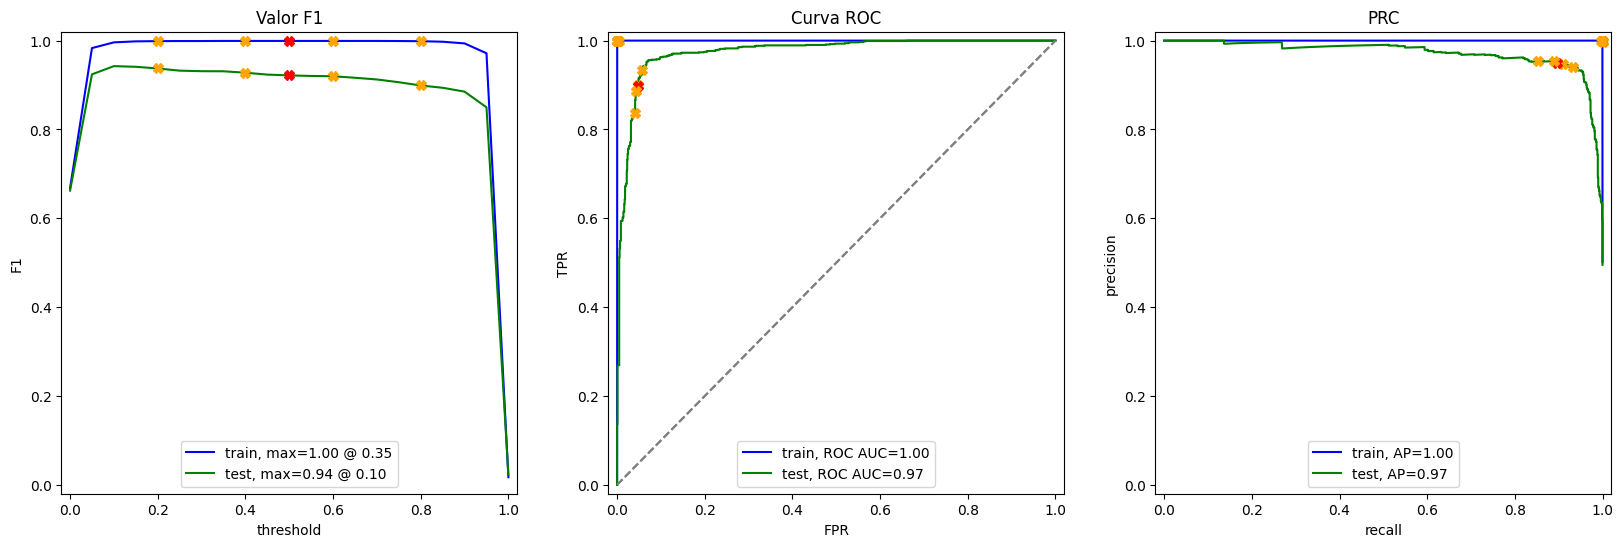

In [106]:
# Definir la grilla de hiperparámetros para la búsqueda en cuadrícula
# Nota los hiperaparámetros puestos a continuación son los obtenidos en la búsqueda
# para minimizar el tiempo de entrenamiento
param_grid = {
    'objective': ['binary:logistic'],
    'eval_metric': ['auc'],
    'learning_rate': [0.1],
    'max_depth': [24],
    'reg_lambda': [1],
    'n_estimators': [1000],
}

# Definir el modelo XGBClassifier
xgb_classifier = xgb.XGBClassifier()

# Realizar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(features_train_encoded.values, target_train.values)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros encontrados:", best_params)

# Evaluar el mejor modelo para Exactitud, F1, APS, ROC-AUC
best_model = grid_search.best_estimator_
evaluate_model(best_model, features_train_encoded, target_train, features_test_encoded, target_test)

## <a id='toc1_9_'></a>[Conclusiones y recomendaciones](#toc0_)

- Se recomienda revisar electronic check. Debido a que tiene un porcentaje de retención de activos
menor a los otros métodos de pago (54% vs 80%+ de los otro métodos). 
- 2014 y 2019 son años muy buenos en comparación al resto. 
- Febrero es el mes en el que mas usuarios se suman (sobretodo para el contrato de 2 años). 
- Los contratos de 2 años tienen una tendencia negativa, los contratos por mes se volvieron
mas populares a traves de los años. En 2019 1750 contratos nuevos fueron mes  mes, mientras
que menos de 250 contratos perteneces a contratos de 1 o 2 años.
- Existe un abandono en los últimos 4 meses. La mayoría de contratos de mes a mes (mas del 
75% de los contratos en abandono son de mes a mes).
- Los usuarios paperless_billing en 'si' tienen mayor abandono 66.43% continuan activos, 
en la contraparte se mantienen el 83.66% de los usuarios. 
- Las personas sin dependientes suelen dejar el servicio mas que las que tienen dependientes.
68.72% de las personas con dependientes se mantienen activos, mientras que el 84.55% de las
personas sin dependientes se mantienen activos.
- Las personas con partner mantienen el servicio mas que las que no tienen. Las personas
con partner tienen un 80% de retención mientras que las que no tienen solo el 67%.
- De los servicios de internet:
	- Los usuarios con fibra optica renovaron menos el servicio. Solo el 58% de los usuarios 
	se mantienen activos.
	- Los usuarios que se mantienen mas activos son los que tienen seguridad en linea,
	con un 85% de activos. 
- Correlaciones débiles con is_active (menores a 0.1)
   - El género tiene una correlación de 0.003, es demasiado baja.
   - online_backup y device_protection tienen una correlación positia débil del 0.09. 
   - streaming_tv tiene una correlación negativa débil del -0.06.
   - streaming_movies y multiple_lines tienen una correlación negativa débil del -0.04.

- Correlaciones fuertes on is_active
   - total_charges tiene una correlación positiva.
   - type tiene una correlación positiva fuerte.

Comparación de modelos por tiempo de ejecución y métricas ROC-AUC, F1 y Accuracy. 

| Modelo              | Tiempo de entrenamiento | ROC-AUC |  F1  | Accuracy |
|---------------------|-------------------------|---------|------|----------|
| Dummy               |          0 s            |   0.50  | 0.66 |   0.50   |
| Logistic Regression |          0 s            |   0.81  | 0.73 |   0.73   |
| Catboost            |       5 min 19 s        |   0.96  | 0.90 |   0.90   |
| LightGBM            |       1 min 47 s        |   0.97  | 0.93 |   0.93   |
| XGBoost             |       15 min 2 s        |   0.97  | 0.94 |   0.92   |

Se recomienda el modelo LightGBM Por mantener métricas superiores y un tiempo de entrenamiento relativamente bajo. 

## <a id='toc1_10_'></a>[Informe](#toc0_)

- ¿Qué pasos del plan se realizaron y qué pasos se omitieron (explica por qué)?
  En general, el plan es realizo como se planteo, hubieron algunos pasos extras debido a los patrones que se iban descubriendo mientras se codificaba.

  Pasos que realize:
  - EDA profundo: se analizaron mas las correlaciones y el como afectaban las características al abandono del servicio. 
  - Se añadieron graficos que ayudaran al entendimiento de los datos, por ejemplo los usuarios que dejan el servicio por año y por tipo de contrato o 
  aquellos nuevos usuarios por año y por tipo de contrato.
  - Preprocesamiento: Muchas columnas no estaban en un formato adecuado del tipo de dato. La ventaja con la información es que la mayoría eran columnas
  con 2 valores, lo que permitio convertir la column al tipo bool.
  - Fue neceasario crear un unico dataframe reuniendo todas las características de los dataframes individuales.
  - Preparar los datos para los modelos: En este caso era transformar las variables categoricas a númericas y para algunos casos, escalar los datos.
  Fue necesario implementar tanto One Hot Encoding par las variables sin orden asi como Label Enconding para las que seguian un orden.
  - Feature engineering: Se utilizaron algoritmos como boruta para ver la importancia de cada característica con un modelo base (bosque aleatorio).
  de esta forma se eliminaron bastantes columnas.
  - Se implementaron 5 modelos: dummy, logistic regression, catboos, lightGBM y XGBoost. De estos se compararon los tiempos de entrenamiento.
  - Se utilizo validación cruzada y la búsqueda de hiperparámetros óptimos para cada modelo.
  - Las métricas del conjunto de prueba fueron: ROC-AUC (principal), F1 y Accuracy como secundarias.
  
Pasos que omiti:
- Se omitio la creación de una columna con la fecha de terminación del contrato. La razon es que trasmite información del objetivo al modelo. 
  


- ¿Qué dificultades encontraste y cómo lograste resolverlas?
  Al principio, encontrar que características son importantes por el modelo parecia dificil. Tuve que aprender a usar algoritmos como Boruta para resolver el problema. 

  Otro problema fue determinar por que el modelo me daba calidad perecta. Esto fue ocacionado por una columna que cree a partir de la fecha de terminación de los contratos, la cual extraia el año y el mes. Esta columna sirve para analizar el comportamiento de los usuarios mas no para el modelo. 

  Otra caso fue la instalación de librerías en un entorno nuevo. Realmente fue algo complicado hacerlo desde 0 sin anaconda. Lo resolví retomando mis notas de entornos virtuales, utilizando comandos sencillos pra la creacion de venv. 

  Despues me di cuenta que entre mas exploraba los datos mas incognitas salian. Mas ideas habia y por lo tanto mas formas de solucionar el problema
  es planteaban. Creo que mi falta de experiencia me hizo desarrollar un plan general y espero en el futuro hacer planes mas especificos. Lo que hice fue 
  apoyarme de los distintos ejercicios que realize a traves del bootcamp para ir acotando lo que se puede y no hacer en el proyecto. 


- ¿Cuáles fueron algunos de los pasos clave para resolver la tarea?
  Yo dividiria los aspectos clave en: entender la información, como interactuan los datos entre si, patrones y relaciones. Y saber como entregar
  esta información al modelo, es decir, que datos y que tipo de datos haran que mi modelo tenga un mejor desempeño.

  Dicho esto, se exploro a profundidad la información y se aplicaron las transformaciones adecuadas al dataframe asi como la agregación de nuevas
  características a partir de lo observado. 

- ¿Cuál es tu modelo final y qué nivel de calidad tiene?

  Se selecciono el modelo `LightGBM` porque obtuvo la calidad mas alta (`0.97` para la métrica principal ROC-AUC). Ademas de un tiempo considerablemente mas bajo de entrenamiento frente a los otros modelos (1 min 47 seg).

  Los parámetros fueron:
  - 'learning_rate': 0.1 
  - 'max_depth': 24 
  - 'metric': 'auc' 
  - 'n_estimators': 1000 
  - 'num_leaves': 24 
  - 'objective': 'binary' 
  - 'reg_lambda': 1